In [2]:
import os
os.environ["KERAS_BACKEND"]="tensorflow"
import tensorflow as tf
import keras_cv
import keras
print("Tensorflow ",tf.__version__)
print("keras ", keras.__version__)
print("Nombre de GPUs disponibles :", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

Tensorflow  2.15.0
keras  2.15.0
Nombre de GPUs disponibles : 1
True


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras_cv.layers import Resizing
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import RandomNormal
from livelossplot import PlotLossesKeras
import time

# construction d'un modèle CNN 

## 1. test avec trois classes :

In [23]:
imag_dir = "Images"
class_names = os.listdir(path=imag_dir)
# Je choisis 3 classe parmi les 120 classes
selected_classes = class_names[:3]
selected_classes

['n02096437-Dandie_Dinmont', 'n02112137-chow', 'n02105855-Shetland_sheepdog']

In [29]:
# chargement des images des classes sélectionnées : train
train_images = []
train_labels = []

data_train_dir = os.path.join("data", "train")

for class_name in selected_classes:
    class_dir = os.path.join(data_train_dir, class_name)
    image_files = os.listdir(class_dir)
    for image_file in image_files:
        image_path = os.path.join(class_dir, image_file)
        image = load_img(image_path)
        resized_image = Resizing(height=224, 
                                 width=224,
                                 interpolation="bilinear",
                                 crop_to_aspect_ratio=False,
                                 pad_to_aspect_ratio=True,
                                 bounding_box_format=None)(image)
        image_array = img_to_array(resized_image)/255.0 # normalisation
        train_images.append(image_array)
        train_labels.append(class_name)
# Convertir la liste d'images et liste de labels en tableau numpy
train_images = np.array(train_images)
train_labels = np.array(train_labels)

print("Dimension des images d'entrainement :", train_images.shape)
print("Dimensions des étiquettes d'entraînement :", train_labels.shape)

Dimension des images d'entrainement : (399, 224, 224, 3)
Dimensions des étiquettes d'entraînement : (399,)


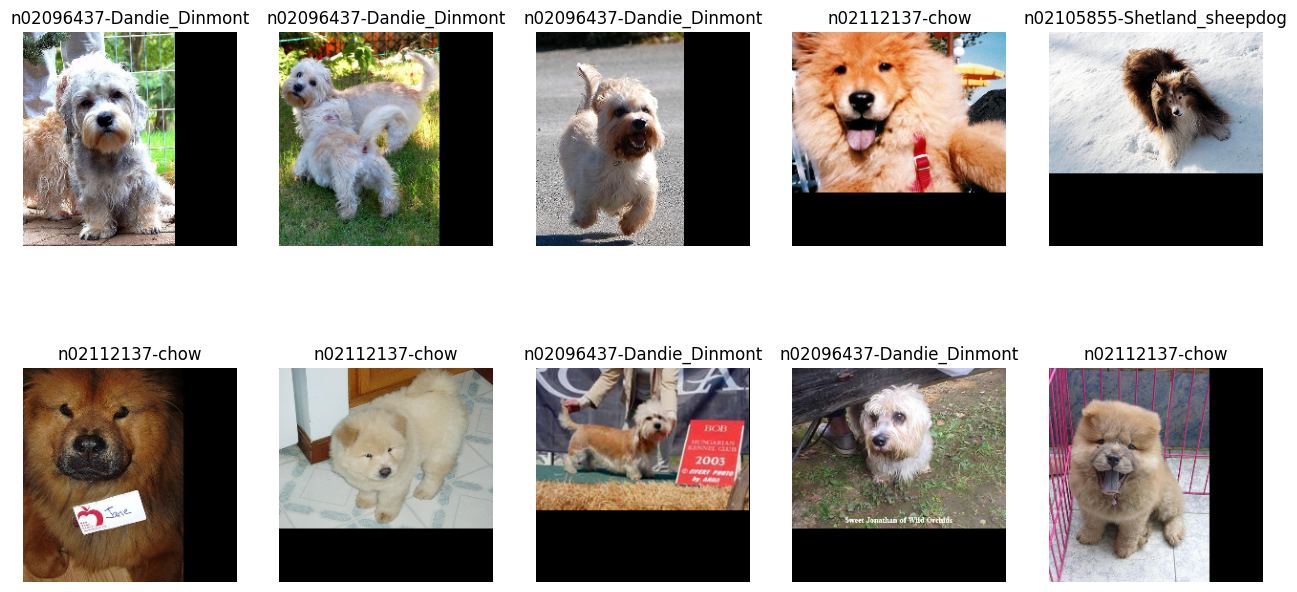

In [38]:
# Définir le nombre d'images à afficher
num_images_to_display = 10

# Sélectionner 10 indices aléatoires parmi les indices disponibles
random_indices = random.sample(range(len(train_images)), num_images_to_display)
plt.figure(figsize=(16,8))
# Afficher les images correspondant aux indices sélectionnés
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1) 
    plt.imshow(train_images[idx])
    plt.title(train_labels[idx])  # Utiliser l'étiquette correspondant à l'indice sélectionné
    plt.axis('off')  # Masquer les axes
plt.show()

In [10]:
def load_images(path, selected_class):
    images = []
    labels = []
    data_dir = os.path.join("data", path)
    for class_name in selected_class:
        class_dir = os.path.join(data_dir, class_name)
        image_files = os.listdir(class_dir)
        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)
            image = load_img(image_path)
            resized_image = Resizing(height=224, 
                                     width=224,
                                     interpolation="bilinear",
                                     crop_to_aspect_ratio=False,
                                     pad_to_aspect_ratio=True,
                                     bounding_box_format=None)(image)
            image_array = img_to_array(resized_image) / 255.0 
            images.append(image_array)
            labels.append(class_name) 
    images = np.array(images)
    labels = np.array(labels)
    return(images, labels)

In [41]:
validation_images, validation_labels = load_images(path="val", selected_class=selected_classes)
print("Dimension des images de validation :", validation_images.shape)
print("Dimensions des étiquettes de validation :", validation_labels.shape)

Dimension des images de validation : (79, 224, 224, 3)
Dimensions des étiquettes de validation : (79,)


In [42]:
test_images, test_labels = load_images(path="test", selected_class=selected_classes)
print("Dimension des images de test :", test_images.shape)
print("Dimensions des étiquettes de test :", test_labels.shape)

Dimension des images de test : (55, 224, 224, 3)
Dimensions des étiquettes de test : (55,)


In [45]:
# Instanciation de l'encodeur de labels
label_encoder = LabelEncoder()

# Adapter l'encodeur de labels aux noms de classes
label_encoder.fit(selected_classes)

# Encodage des noms de classes en entiers
train_labels_encoded = label_encoder.transform(train_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [50]:
test_labels_encoded

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Test n°1 :

In [51]:
model = Sequential([
    # Première couche de convolution
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    
    # Couche de pooling pour réduire les dimensions
    MaxPooling2D((2, 2)),

    # Deuxième couche de convolution
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Troisème couche de convolution
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Aplatir les données pour les passer à travers les couches entièrement connectées
    Flatten(),
    
    # Couche fully connected (Dense) avec 128 neurones
    Dense(128, activation='relu'),
    
    # Couche de sortie avec un neurone par classe
    Dense(len(selected_classes), activation='softmax')
])

In [ ]:
# Compilation du modèle

In [52]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      

In [ ]:
# Entraînement du modèle

In [54]:
history = model.fit(x=train_images,
                    y=train_labels_encoded,
                    epochs=5,
                    verbose=1,
                    validation_data=(validation_images,validation_labels_encoded),
                    shuffle=True
                   )


Epoch 1/5


2024-02-29 16:32:10.314505: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-02-29 16:32:10.776680: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-29 16:32:11.337497: I external/local_xla/xla/service/service.cc:168] XLA service 0x5625e1d0f480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-29 16:32:11.337512: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2024-02-29 16:32:11.340971: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709220731.403452  150775 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 [==============================] - 8s 200ms/step - loss: 1.2583 - accuracy: 0.3910 - val_loss: 1.0382 - val_accuracy: 0.4684
Epoch 2/5
13/13 [==============================] - 1s 47ms/step - loss: 0.9116 - accuracy: 0.5739 - val_loss: 1.0725 - val_accuracy: 0.5063
Epoch 3/5
13/13 [==============================] - 1s 47ms/step - loss: 0.7478 - accuracy: 0.6842 - val_loss: 0.9633 - val_accuracy: 0.5823
Epoch 4/5
13/13 [==============================] - 1s 47ms/step - loss: 0.5735 - accuracy: 0.7719 - val_loss: 1.4531 - val_accuracy: 0.5190
Epoch 5/5
13/13 [==============================] - 1s 46ms/step - loss: 0.4753 - accuracy: 0.8095 - val_loss: 1.3112 - val_accuracy: 0.5696


In [ ]:
# Evaluation du modèle 

In [55]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels_encoded)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

2/2 [==============================] - 0s 355ms/step - loss: 1.0113 - accuracy: 0.5455
Test Loss: 1.0112546682357788
Test Accuracy: 0.5454545617103577


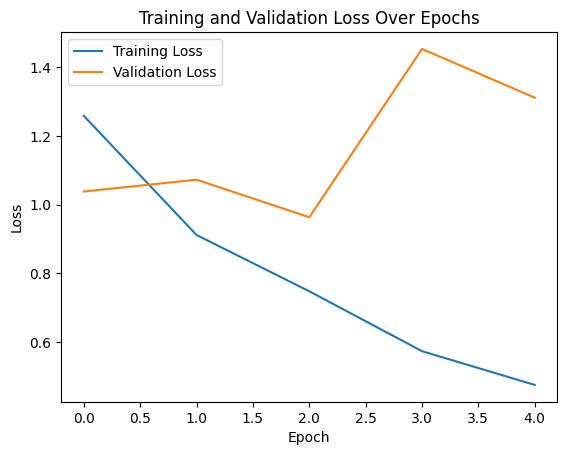

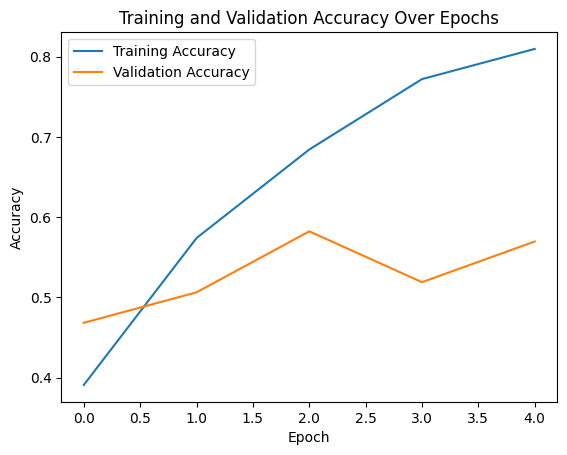

In [56]:
# Affichage de la perte sur les données d'entraînement et de validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Affichage de la précision sur les données d'entraînement et de validation
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

In [57]:
# Continuer l'entraînement avec plus d'époques
history = model.fit(x=train_images,
                    y=train_labels_encoded,
                    epochs=15,  
                    verbose=1,
                    validation_data=(validation_images, validation_labels_encoded),
                    shuffle=True
                   )


Epoch 1/15
13/13 [==============================] - 1s 51ms/step - loss: 0.3163 - accuracy: 0.8797 - val_loss: 1.2592 - val_accuracy: 0.6076
Epoch 2/15
13/13 [==============================] - 1s 47ms/step - loss: 0.1411 - accuracy: 0.9599 - val_loss: 1.9068 - val_accuracy: 0.5570
Epoch 3/15
13/13 [==============================] - 1s 49ms/step - loss: 0.1116 - accuracy: 0.9674 - val_loss: 1.5173 - val_accuracy: 0.6835
Epoch 4/15
13/13 [==============================] - 1s 48ms/step - loss: 0.0427 - accuracy: 0.9925 - val_loss: 2.0853 - val_accuracy: 0.5823
Epoch 5/15
13/13 [==============================] - 1s 49ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 2.1683 - val_accuracy: 0.5949
Epoch 6/15
13/13 [==============================] - 1s 49ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 2.3483 - val_accuracy: 0.6076
Epoch 7/15
13/13 [==============================] - 1s 49ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.4153 - val_accuracy: 0.6076
Epoch 8/15
13

In [58]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels_encoded)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

2/2 [==============================] - 0s 15ms/step - loss: 2.2505 - accuracy: 0.6909
Test Loss: 2.2504916191101074
Test Accuracy: 0.6909090876579285


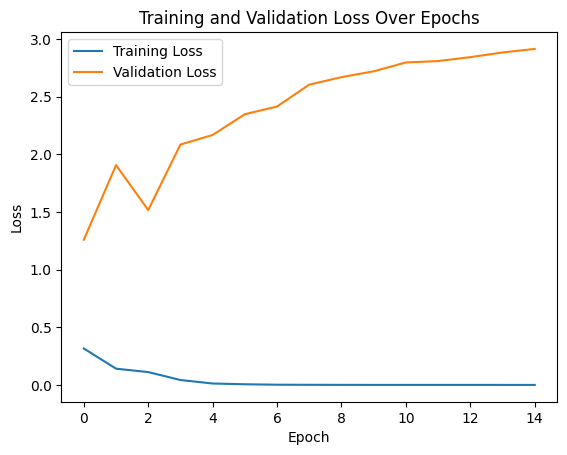

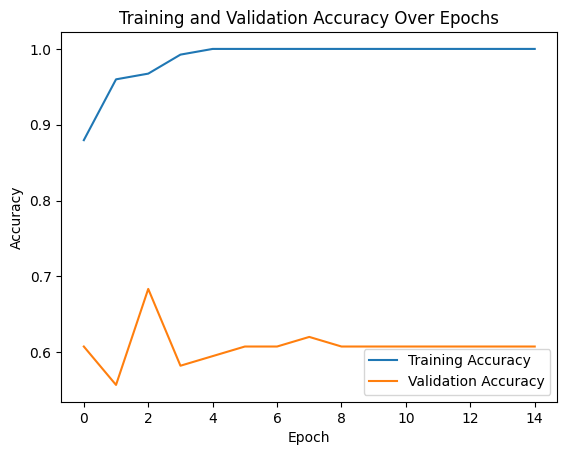

In [59]:
# Affichage de la perte sur les données d'entraînement et de validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Affichage de la précision sur les données d'entraînement et de validation
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

En augmentant le nombre d'époque, on constate que le modèle surapprend sur les données d'entrainement et ne généralise pas sur les données de validation, ce qui indique un overfiting.

### Test n°2 :

Nous reprenons le modèle précédent avec quelques ajouts: 

    - Régularisation l2 : qui est une pénalité ajoutée à la fonction de perte des poids 
    - Couche de Dropout : qui désactive aléatoirement certain neuronnes
    - EarlyStopping de keras.callback pour empêcher l'overfiting en arrêtant l'entraînement du modèle

In [82]:
model1 = Sequential([

    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    
    Dropout(0.5),
    Dense(len(selected_classes), activation='softmax')
])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='Models/model1.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [86]:

model1.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model1.fit(train_images, train_labels_encoded,
                    epochs=50,
                    validation_data=(validation_images, validation_labels_encoded),
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 0.6176 - accuracy: 0.8446
Epoch 1: val_accuracy did not improve from 0.64557
13/13 [==============================] - 1s 57ms/step - loss: 0.6176 - accuracy: 0.8446 - val_loss: 1.3839 - val_accuracy: 0.5316
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 0.4889 - accuracy: 0.8872
Epoch 2: val_accuracy did not improve from 0.64557
13/13 [==============================] - 1s 48ms/step - loss: 0.4889 - accuracy: 0.8872 - val_loss: 1.5090 - val_accuracy: 0.5443
Epoch 3/50
12/13 [==========================>...] - ETA: 0s - loss: 0.4172 - accuracy: 0.9141
Epoch 3: val_accuracy did not improve from 0.64557
13/13 [==============================] - 1s 51ms/step - loss: 0.4138 - accuracy: 0.9148 - val_loss: 1.5620 - val_accuracy: 0.5190
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 0.3225 - accuracy: 0.9624
Epoch 4: val_accuracy did not improve from 0.64557
13/13 [=======================

In [87]:
test_loss, test_accuracy = model1.evaluate(test_images, test_labels_encoded)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

2/2 [==============================] - 0s 14ms/step - loss: 1.2643 - accuracy: 0.7636
Test Loss: 1.2643083333969116
Test Accuracy: 0.7636363506317139


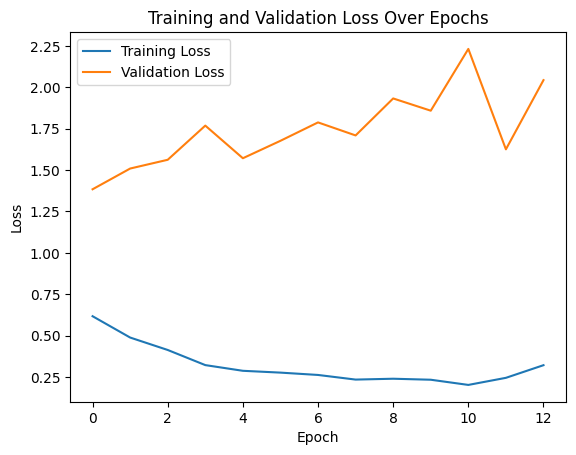

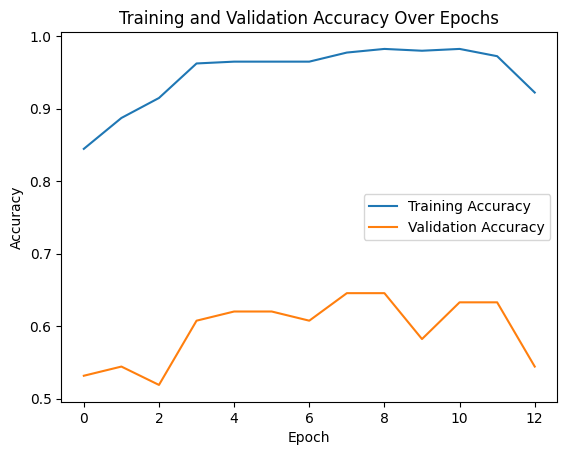

In [88]:
# Affichage de la perte sur les données d'entraînement et de validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Affichage de la précision sur les données d'entraînement et de validation
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

### Test n°3

!pip install livelossplot

In [90]:
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_initializer=RandomNormal(seed=0) ,kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),    
    Conv2D(64, (3, 3), activation='relu', kernel_initializer=RandomNormal(seed=0), kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_initializer=RandomNormal(seed=0), kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', kernel_initializer=RandomNormal(seed=0), kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu', kernel_initializer=RandomNormal(seed=0), kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(265, activation='relu'),
    Dropout(0.5),
    Dense(len(selected_classes), activation='softmax')
])
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='Models/model2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [92]:
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 26, 26, 128)      

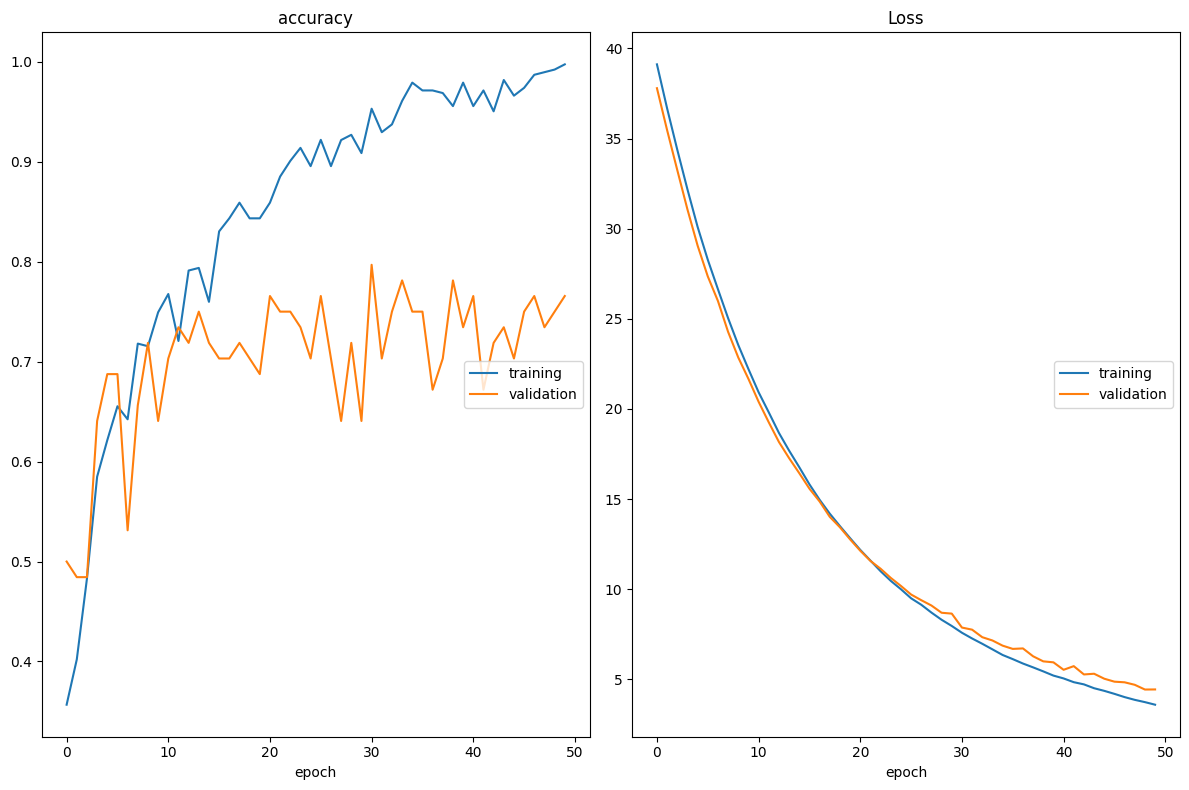

accuracy
	training         	 (min:    0.357, max:    0.997, cur:    0.997)
	validation       	 (min:    0.484, max:    0.797, cur:    0.766)
Loss
	training         	 (min:    3.593, max:   39.118, cur:    3.593)
	validation       	 (min:    4.434, max:   37.795, cur:    4.439)

Epoch 50: val_loss did not improve from 4.43407
24/24 [==============================] - 1s 38ms/step - loss: 3.5925 - accuracy: 0.9974 - val_loss: 4.4390 - val_accuracy: 0.7656


In [95]:
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
batch_size=16
epochs=50
train_size=train_images.shape[0]
val_size=validation_images.shape[0]
history = model2.fit(train_images, train_labels_encoded,
                     epochs=epochs,
                     batch_size= batch_size,
                     steps_per_epoch=train_size//batch_size,
                     validation_steps=val_size//batch_size,
                     validation_data=(validation_images, validation_labels_encoded),
                     callbacks=[plotloss, early_stopping, model_checkpoint],
                    )


In [96]:
test_loss, test_accuracy = model2.evaluate(test_images, test_labels_encoded)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

2/2 [==============================] - 0s 211ms/step - loss: 4.5833 - accuracy: 0.5818
Test Loss: 4.583309173583984
Test Accuracy: 0.581818163394928


In [117]:
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='Models/model2_bis.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

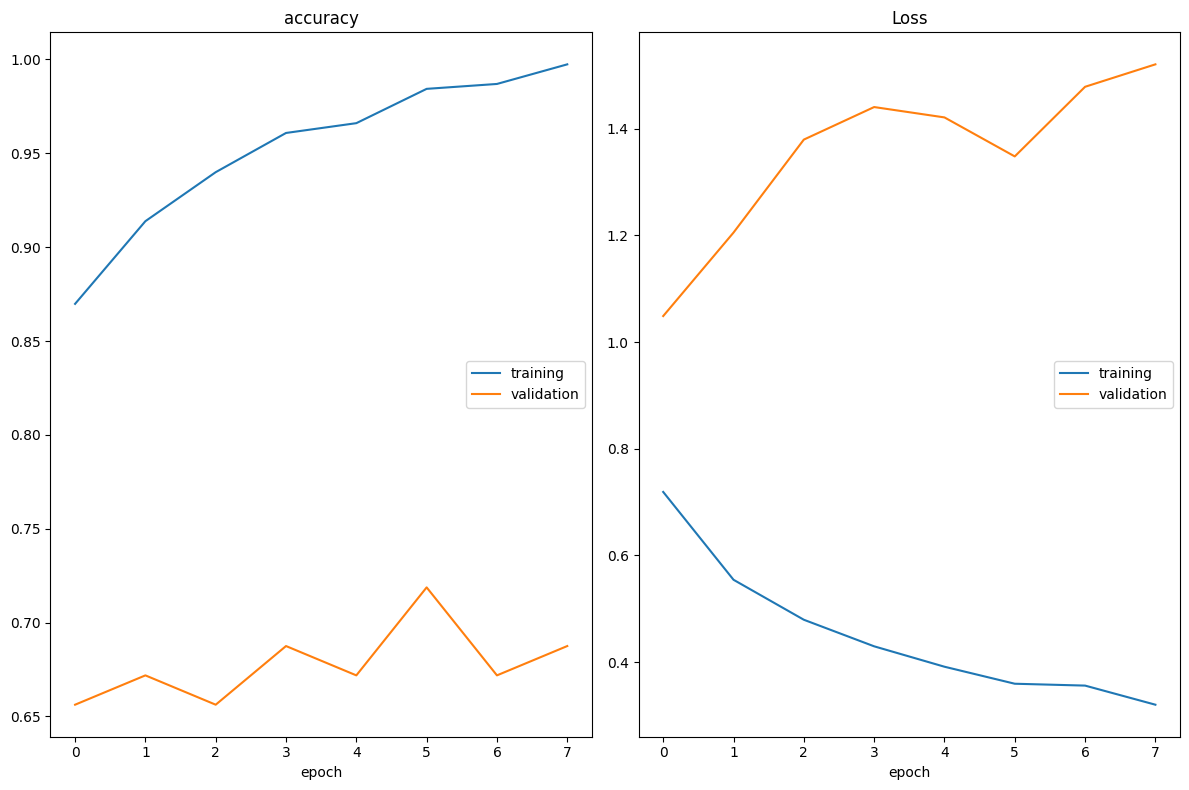

accuracy
	training         	 (min:    0.870, max:    0.997, cur:    0.997)
	validation       	 (min:    0.656, max:    0.719, cur:    0.688)
Loss
	training         	 (min:    0.320, max:    0.719, cur:    0.320)
	validation       	 (min:    1.049, max:    1.521, cur:    1.521)

Epoch 8: val_loss did not improve from 1.04872
24/24 [==============================] - 1s 39ms/step - loss: 0.3202 - accuracy: 0.9974 - val_loss: 1.5205 - val_accuracy: 0.6875


In [118]:
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
batch_size=16
epochs=80
train_size=train_images.shape[0]
val_size=validation_images.shape[0]
history = model2.fit(train_images, train_labels_encoded,
                     epochs=epochs,
                     batch_size= batch_size,
                     steps_per_epoch=train_size//batch_size,
                     validation_steps=val_size//batch_size,
                     validation_data=(validation_images, validation_labels_encoded),
                     callbacks=[plotloss, early_stopping, model_checkpoint],
                    )

In [119]:
test_loss, test_accuracy = model2.evaluate(test_images, test_labels_encoded)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

2/2 [==============================] - 0s 18ms/step - loss: 1.2305 - accuracy: 0.6545
Test Loss: 1.2305231094360352
Test Accuracy: 0.6545454263687134


## 2. test avec toutes les classes :

In [5]:
imag_dir = "Images"
class_names = os.listdir(path=imag_dir)
print("nombre de classes :", len(class_names))

nombre de classes : 120


In [12]:
# all_test_images, all_test_labels = load_images(path="test", selected_class=class_names)
# print("Dimension des images de test :", all_test_images.shape)
# print("Dimensions des étiquettes de test :", all_test_labels.shape)

2024-02-29 23:53:42.766083: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 23:53:42.766213: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 23:53:42.766285: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Dimension des images de test : (2161, 224, 224, 3)
Dimensions des étiquettes de test : (2161,)


In [121]:
all_val_images, all_val_labels = load_images(path="val", selected_class=class_names)
print("Dimension des images de validation :", all_val_images.shape)
print("Dimensions des étiquettes de validation :", all_val_labels.shape)

120

In [ ]:
all_train_images, all_train_labels = load_images(path="train", selected_class=class_names)
print("Dimension des images de train :", all_train_images.shape)
print("Dimensions des étiquettes de train :", all_train_labels.shape)

Cette méthode est très gourmande en ressource et fait planter le noyau

In [4]:
from tensorflow.keras.preprocessing.image import save_img

In [7]:
# Redimensionner les images en utilisant Resizing de Keras_cv et sauvegarder les images dans un nouveau répetoire

for class_name in class_names:
    class_dir = os.path.join("Images", class_name)
    resized_class_dir = os.path.join("Resized_Images", class_name)
    os.makedirs(resized_class_dir, exist_ok=True)
    image_files = os.listdir(class_dir)
    for image_file in image_files:
        image_path = os.path.join(class_dir, image_file)
        image = load_img(image_path)
        resized_image = Resizing(height=256, 
                                 width=256, 
                                 interpolation="bilinear", 
                                 crop_to_aspect_ratio=False, 
                                 pad_to_aspect_ratio=True, 
                                 bounding_box_format=None)(image)
        save_img(os.path.join(resized_class_dir, image_file), resized_image)

2024-03-01 13:41:17.701369: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 13:41:17.701523: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 13:41:17.701609: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
# Charger les données à partir des répertoires redimensionnés

train_data, val_test = tf.keras.preprocessing.image_dataset_from_directory(
    "Resized_Images",
    labels="inferred",
    label_mode="int",
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=0,
    validation_split=0.25,  # la proportion de données à utiliser pour la validation + test
    subset="both",
)

Found 20580 files belonging to 120 classes.
Using 15435 files for training.
Using 5145 files for validation.


In [6]:
# Mélanger l'ensemble validation + test
val_test_shuffled = val_test.shuffle(buffer_size=len(val_test))

In [7]:
# Définir la taille des ensembles de validation et de test
val_size = int(0.6 * len(val_test_shuffled))

# Séparer les ensembles de validation et de test
val_data = val_test_shuffled.take(val_size)
test_data = val_test_shuffled.skip(val_size)

Vérification que les ensembles  de validation et test sont disjoints

In [8]:
# Créer des listes pour stocker les échantillons des ensembles de validation et de test
val_samples = []
test_samples = []

# Parcourir l'ensemble de validation et stocker les échantillons
for images, labels in val_data:
    val_samples.extend(images.numpy())

# Parcourir l'ensemble de test et stocker les échantillons
for images, labels in test_data:
    test_samples.extend(images.numpy())
# créer deux ensemble d'indice - validation et test 
val_indices = set(range(len(val_samples))) # contient les indice unique des échantillons de validation
test_indices = list(range(len(val_samples), len(val_samples) + len(test_samples))) # contient les tous indices des échantillons de test 

# Si l'intersection est vide, cela signifie qu'il n'y a pas de chevauchement
intersection = val_indices.intersection(test_indices)

if not intersection:
    print("Aucune intersection entre les ensembles de validation et de test.")
else:
    print("Il y a une intersection entre les ensembles de validation et de test.")


Aucune intersection entre les ensembles de validation et de test.


In [40]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3),kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),    
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(265, activation='relu'),
    Dropout(0.5),
    Dense(120, activation='softmax')
])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 30, 30, 128)      

In [42]:
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='Models/model_all.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [43]:
# Compiler le modèle avec les paramètres d'optimisation souhaités et la fonction de perte appropriée
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

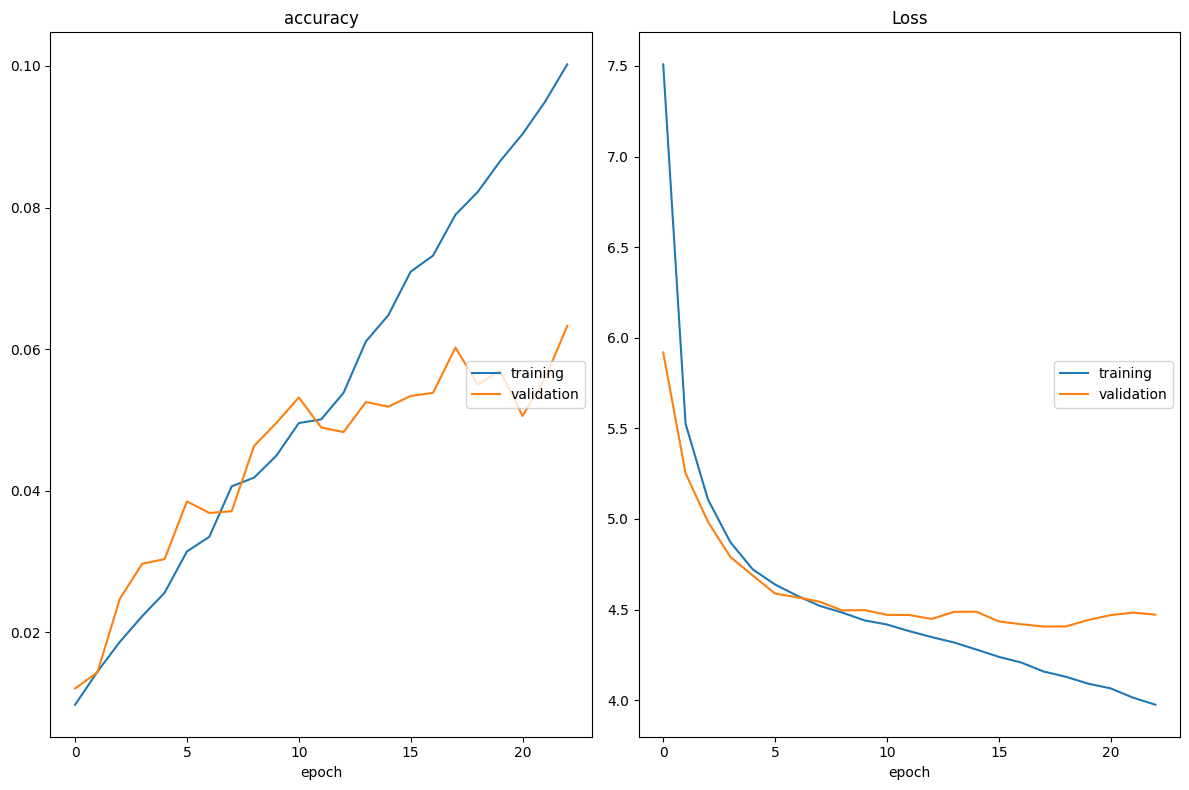

accuracy
	training         	 (min:    0.010, max:    0.100, cur:    0.100)
	validation       	 (min:    0.012, max:    0.063, cur:    0.063)
Loss
	training         	 (min:    3.975, max:    7.509, cur:    3.975)
	validation       	 (min:    4.406, max:    5.919, cur:    4.472)

Epoch 23: val_loss did not improve from 4.40643
483/483 [==============================] - 35s 73ms/step - loss: 3.9749 - accuracy: 0.1002 - val_loss: 4.4720 - val_accuracy: 0.0633


In [44]:
# Entraîner le modèle avec toutes les données
history = model.fit(train_data,
                    epochs=50,
                    validation_data=val_data,
                    callbacks=[plotloss, early_stopping, model_checkpoint])


### Test 2 - données complètes - optimisation d'hyperparamètres

!pip install scikeras[tensorflow]

!pip install scikeras

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import BatchNormalization

In [26]:
dropout_rate=0.3
weight_decay=1e-3
model = Sequential([
    BatchNormalization(input_shape=(256, 256, 3)),
    Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l2(weight_decay)),
    MaxPooling2D((2, 2)),    
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(weight_decay)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(weight_decay)),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(weight_decay)),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(weight_decay)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(dropout_rate),
    Dense(120, activation='softmax')
])
    
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Bat  (None, 256, 256, 3)       12        
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                      

In [33]:
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max'),
model_checkpoint = ModelCheckpoint(filepath='model_all3.h5', monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')
callbacks = [plotloss, early_stopping, model_checkpoint]

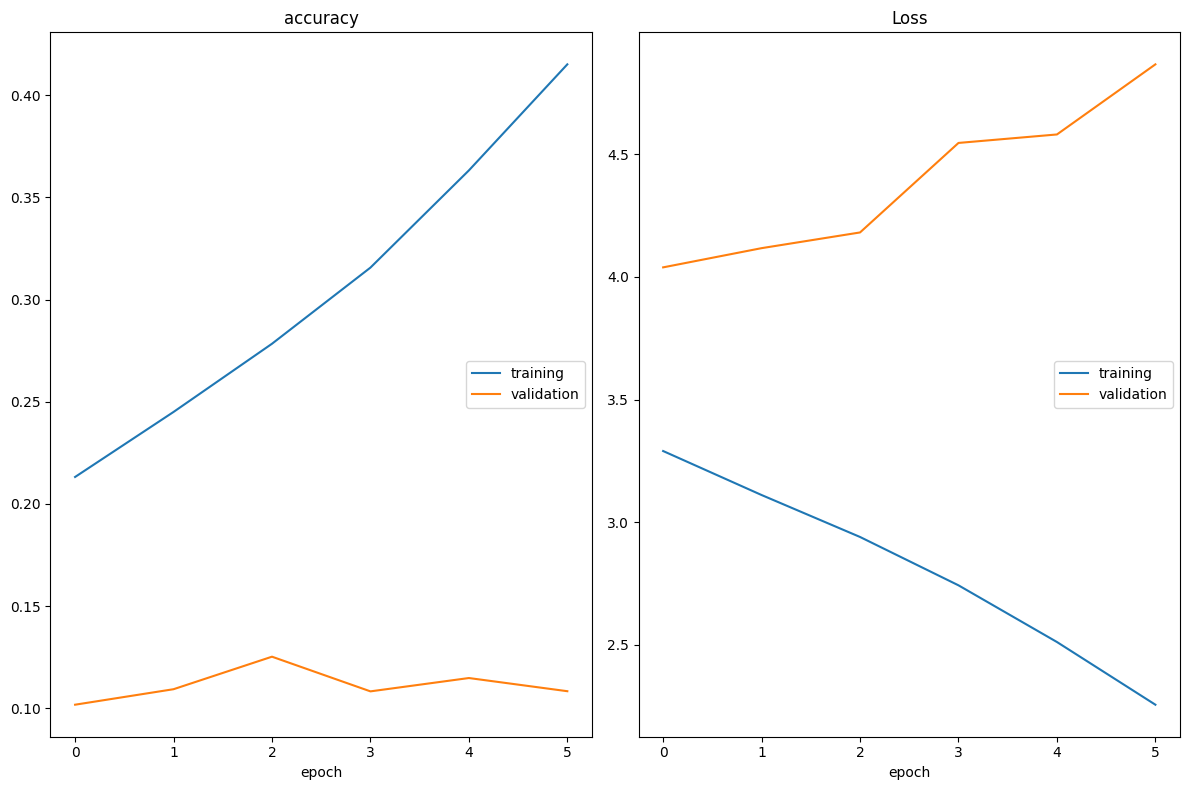

accuracy
	training         	 (min:    0.213, max:    0.415, cur:    0.415)
	validation       	 (min:    0.102, max:    0.125, cur:    0.108)
Loss
	training         	 (min:    2.257, max:    3.290, cur:    2.257)
	validation       	 (min:    4.038, max:    4.865, cur:    4.865)

Epoch 6: val_loss did not improve from 3.94696
483/483 [==============================] - 39s 80ms/step - loss: 2.2567 - accuracy: 0.4151 - val_loss: 4.8652 - val_accuracy: 0.1084


In [18]:
# Entraîner le modèle avec toutes les données
history = model.fit(train_data,
                    epochs=50,
                    validation_data=val_data,
                    callbacks=callbacks)


In [9]:
from tensorflow.keras.layers import Rescaling, BatchNormalization
from tensorflow.keras.layers import Activation, SeparableConv2D, GlobalAveragePooling2D, add

In [41]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = Rescaling(1.0 / 255)(inputs)
    x = Conv2D(64, 3, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512]:
        x = Activation("relu")(x)
        x = SeparableConv2D(size, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = SeparableConv2D(size, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = SeparableConv2D(512, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = GlobalAveragePooling2D()(x)
    
    # Ajoutez une couche Dense pour la classification
    outputs = Dense(num_classes, activation="softmax")(x) 
    return keras.Model(inputs, outputs)


In [42]:
image_size=(256,256)
num_classes=120
model = make_model(input_shape=image_size + (3,), num_classes=num_classes)
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max'),
model_checkpoint = ModelCheckpoint(filepath='model_all4.h5', monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')
callbacks = [plotloss, early_stopping, model_checkpoint]

In [61]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 256, 256, 3)          0         ['input_7[0][0]']             
                                                                                                  
 conv2d_24 (Conv2D)          (None, 128, 128, 64)         1792      ['rescaling_5[0][0]']         
                                                                                                  
 batch_normalization_17 (Ba  (None, 128, 128, 64)         256       ['conv2d_24[0][0]']           
 tchNormalization)                                                                          

In [62]:
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

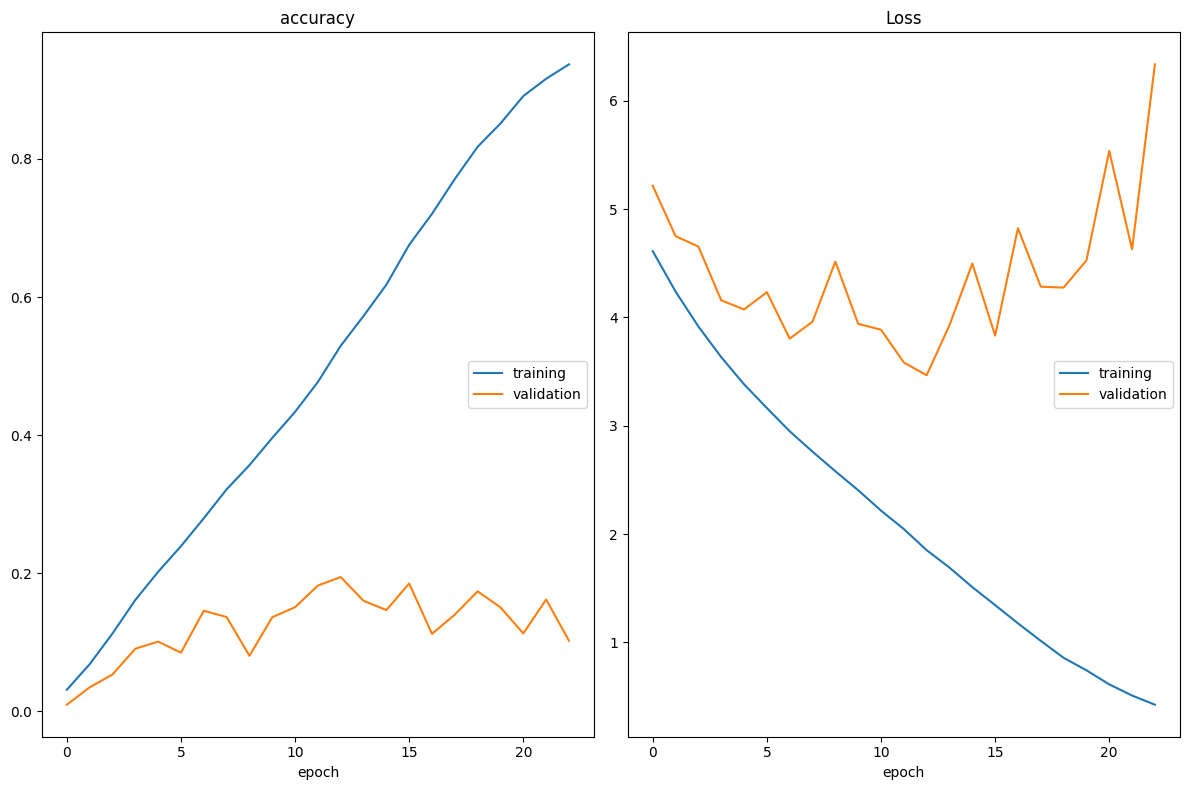

accuracy
	training         	 (min:    0.031, max:    0.937, cur:    0.937)
	validation       	 (min:    0.010, max:    0.195, cur:    0.102)
Loss
	training         	 (min:    0.425, max:    4.611, cur:    0.425)
	validation       	 (min:    3.466, max:    6.335, cur:    6.335)

Epoch 23: val_accuracy did not improve from 0.19466
483/483 [==============================] - 113s 234ms/step - loss: 0.4255 - accuracy: 0.9370 - val_loss: 6.3352 - val_accuracy: 0.1024


In [63]:
epochs=50
history = model.fit(train_data,
                    epochs=epochs,
                    validation_data=val_data,
                    callbacks=callbacks)

On constate un overfiting, on a testé la data augmentation pour améliorer l'apprentissage : 

In [65]:
test_loss, test_accuracy = model.evaluate(test_data)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

65/65 [==============================] - 5s 69ms/step - loss: 3.4215 - accuracy: 0.1995
Test Loss: 3.421548843383789
Test Accuracy: 0.19951923191547394


## Data augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
# Créer une fonction pour appliquer les transformations d'images
def augment_data(images, labels):
    # Convertir les images en flottants et mettre à l'échelle entre 0 et 1
    images = tf.image.convert_image_dtype(images, tf.float32)

    # Appliquer les transformations
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_flip_up_down(images)
    images = tf.image.random_brightness(images, max_delta=0.2)
    images = tf.image.random_contrast(images, lower=0.8, upper=1.2)
    images = tf.image.random_saturation(images, lower=0.8, upper=1.2)
    images = tf.image.random_hue(images, max_delta=0.1)

    return images, labels

# Appliquer les transformations sur les données d'entraînement
train_data_augmented = train_data.map(augment_data)

In [12]:
import matplotlib.pyplot as plt

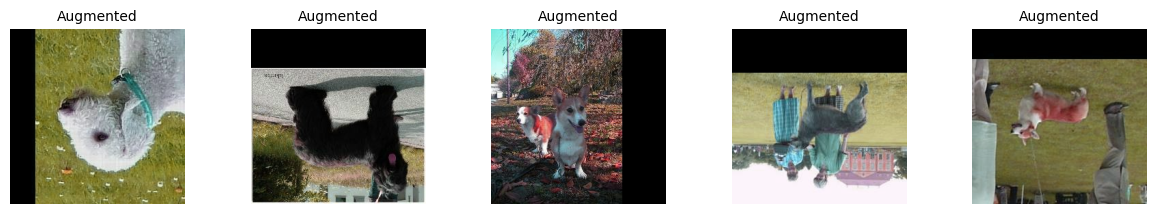

In [25]:
# Récupérer un lot d'images augmentées
for images, labels in train_data_augmented.take(1):
    augmented_images, _ = augment_data(images, labels)
    
    # Afficher les images augmentées et remises à l'échelle
    plt.figure(figsize=(15, 5))
    for i in range(num_images_to_visualize):
        plt.subplot(2, num_images_to_visualize, i + 1)
        plt.imshow(augmented_images[i] / 255.0)  # Remise à l'échelle des valeurs des pixels
        plt.title("Augmented", fontsize=10)
        plt.axis("off")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


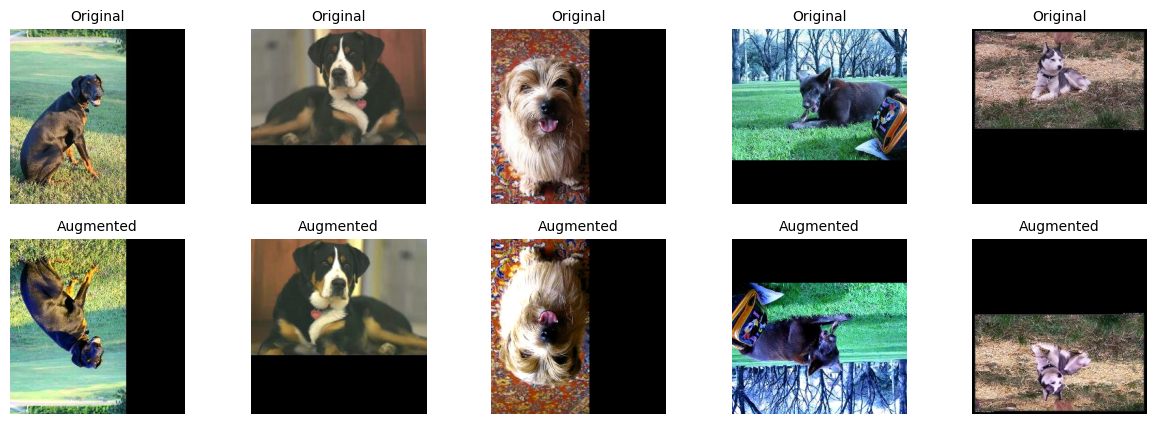

In [28]:
# Récupérer un lot d'images d'origine et augmentées
for images, labels in train_data.take(1):
    original_images = images
    augmented_images, _ = augment_data(images, labels)
    
    # Afficher les images d'origine et les images augmentées
    plt.figure(figsize=(15, 5))
    for i in range(num_images_to_visualize):
        plt.subplot(2, num_images_to_visualize, i + 1)
        plt.imshow(original_images[i] / 255.0)  
        plt.title("Original", fontsize=10)
        plt.axis("off")
        
        plt.subplot(2, num_images_to_visualize, num_images_to_visualize + i + 1)
        plt.imshow(augmented_images[i] / 255.0)  
        plt.title("Augmented", fontsize=10)
        plt.axis("off")

plt.show()


In [13]:
from tensorflow.keras.models import load_model

In [30]:
# Charger le modèle à partir du point de contrôle sauvegardé
saved_model = load_model('model_all4.h5')

In [31]:
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max'),
model_checkpoint = ModelCheckpoint(filepath='model_all_improved.h5', monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')
callbacks = [plotloss, early_stopping, model_checkpoint]

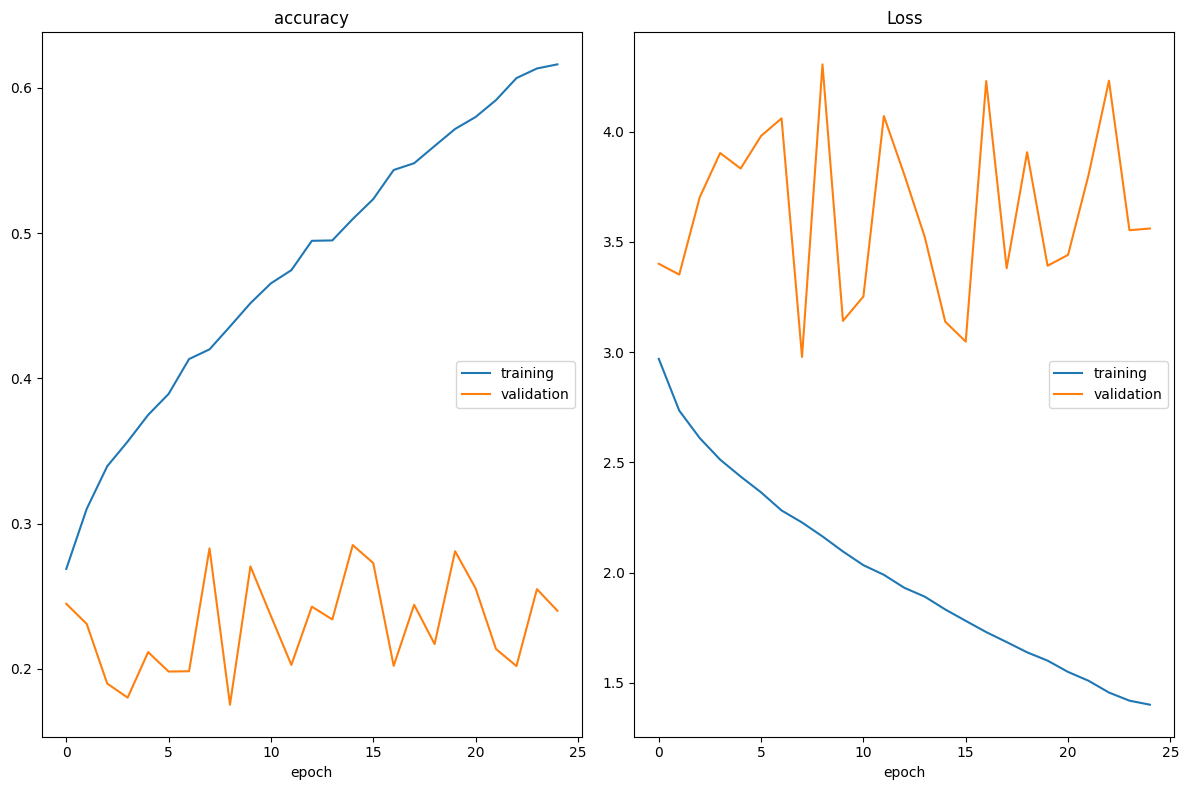

accuracy
	training         	 (min:    0.269, max:    0.616, cur:    0.616)
	validation       	 (min:    0.175, max:    0.285, cur:    0.240)
Loss
	training         	 (min:    1.401, max:    2.969, cur:    1.401)
	validation       	 (min:    2.978, max:    4.305, cur:    3.560)

Epoch 25: val_accuracy did not improve from 0.28515
483/483 [==============================] - 114s 237ms/step - loss: 1.4008 - accuracy: 0.6163 - val_loss: 3.5605 - val_accuracy: 0.2399


In [34]:
# Reprendre l'entraînement du modèle en utilisant les données augmentées
epochs=50
history = saved_model.fit(train_data_augmented,
                          epochs=epochs,
                          validation_data=val_data,
                          callbacks=callbacks)

In [35]:
test_loss, test_accuracy = saved_model.evaluate(test_data)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

65/65 [==============================] - 5s 69ms/step - loss: 3.1781 - accuracy: 0.2769
Test Loss: 3.1781327724456787
Test Accuracy: 0.2769230902194977


In [43]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = Rescaling(1.0 / 255)(inputs)
    x = Conv2D(64, 3, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512]:
        x = Activation("relu")(x)
        x = SeparableConv2D(size, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = SeparableConv2D(size, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = SeparableConv2D(512, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    # Ajoutez une couche Dense pour la classification
    outputs = Dense(num_classes, activation="softmax")(x) 
    return keras.Model(inputs, outputs)


In [47]:
image_size=(256,256)
num_classes=120
model = make_model(input_shape=image_size + (3,), num_classes=num_classes)
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max'),
model_checkpoint = ModelCheckpoint(filepath='model_all_last.h5', monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')
callbacks = [plotloss, early_stopping, model_checkpoint]

In [50]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

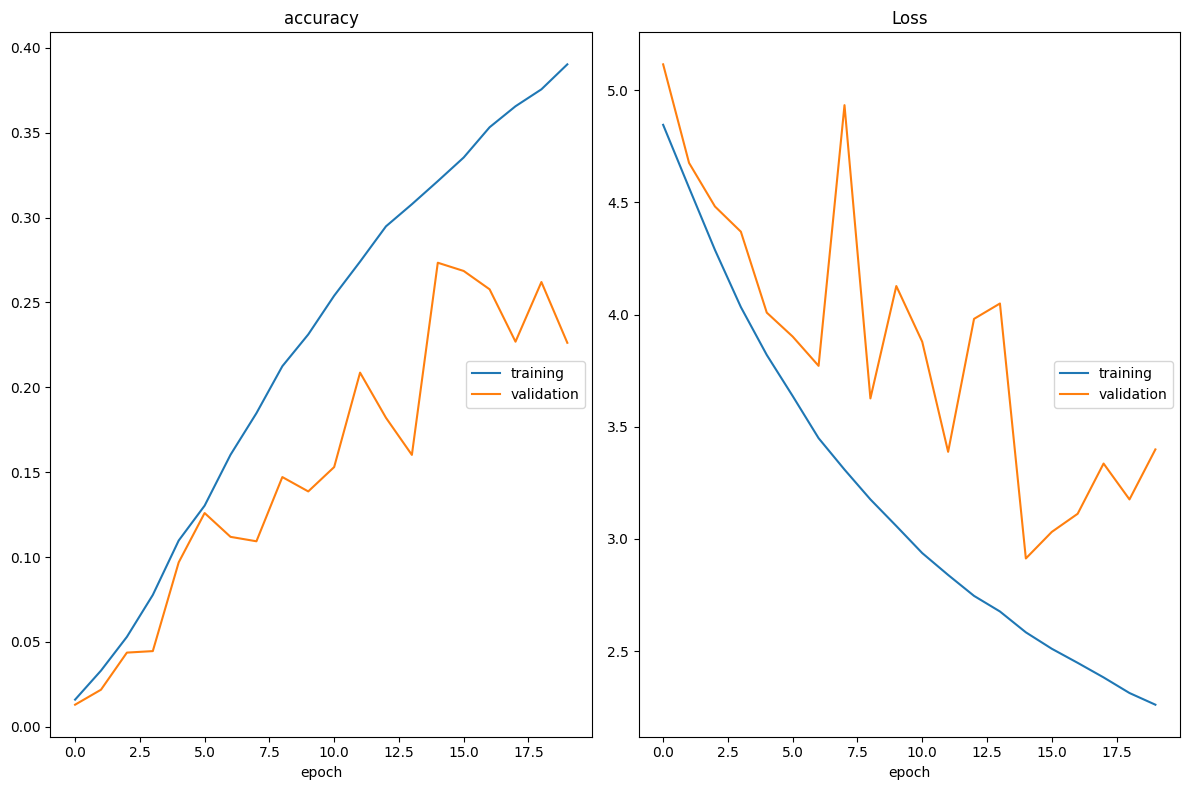

accuracy
	training         	 (min:    0.016, max:    0.390, cur:    0.390)
	validation       	 (min:    0.013, max:    0.273, cur:    0.226)
Loss
	training         	 (min:    2.261, max:    4.846, cur:    2.261)
	validation       	 (min:    2.913, max:    5.115, cur:    3.399)

Epoch 20: val_accuracy did not improve from 0.27341
483/483 [==============================] - 114s 237ms/step - loss: 2.2608 - accuracy: 0.3903 - val_loss: 3.3988 - val_accuracy: 0.2262


In [51]:
# Reprendre l'entraînement du modèle en utilisant les données augmentées
epochs=20
history = model.fit(train_data_augmented,
                          epochs=epochs,
                          validation_data=val_data,
                          callbacks=callbacks)

In [52]:
test_loss, test_accuracy = model.evaluate(test_data)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

65/65 [==============================] - 5s 69ms/step - loss: 2.9991 - accuracy: 0.2692
Test Loss: 2.9990923404693604
Test Accuracy: 0.26917511224746704


On constate une amélioration suite à l'ajout de la couche dropout(0.5) au modèle.. Nous allons à présent reprendre l'entrainement du modèle avec les données originales et les données augmentées.

In [14]:
# Concaténer les données initiales et les données augmentées
combined_train_data = train_data_augmented.concatenate(train_data)

In [16]:
len(combined_train_data)

966

In [18]:
# Charger le modèle à partir du point de contrôle sauvegardé
saved_model = load_model('model_all_last.h5')

In [19]:
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max'),
model_checkpoint = ModelCheckpoint(filepath='model_all_last_improuved.h5', monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')
callbacks = [plotloss, early_stopping, model_checkpoint]

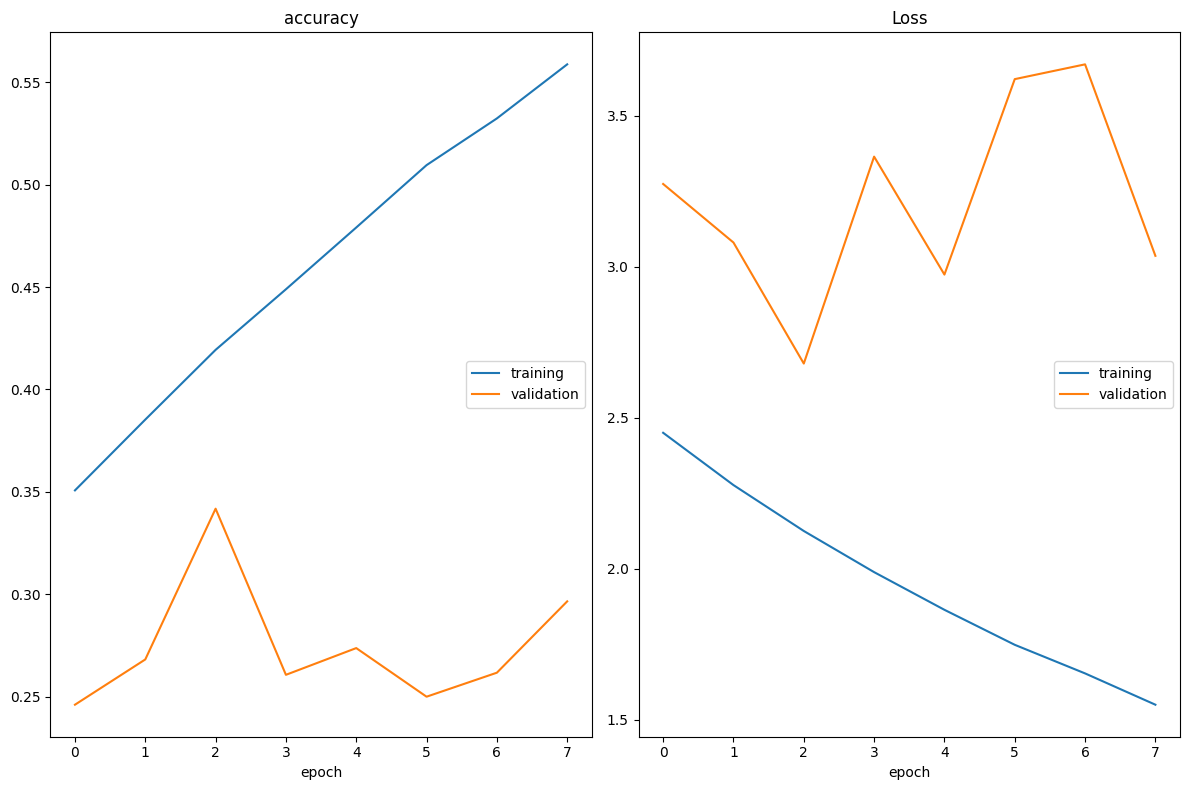

accuracy
	training         	 (min:    0.351, max:    0.559, cur:    0.559)
	validation       	 (min:    0.246, max:    0.342, cur:    0.297)
Loss
	training         	 (min:    1.550, max:    2.450, cur:    1.550)
	validation       	 (min:    2.680, max:    3.670, cur:    3.036)

Epoch 8: val_accuracy did not improve from 0.34180
966/966 [==============================] - 221s 229ms/step - loss: 1.5501 - accuracy: 0.5587 - val_loss: 3.0362 - val_accuracy: 0.2965


In [20]:
# Reprendre l'entraînement du modèle en utilisant les données augmentées et les données originales
epochs=50
history = saved_model.fit(combined_train_data,
                          epochs=epochs,
                          validation_data=val_data,
                          callbacks=callbacks)

In [21]:
test_loss, test_accuracy = saved_model.evaluate(test_data)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

65/65 [==============================] - 5s 69ms/step - loss: 2.6648 - accuracy: 0.3380
Test Loss: 2.6648025512695312
Test Accuracy: 0.3379807770252228


In [22]:
# Charger le modèle à partir du point de contrôle sauvegardé
saved_model = load_model('model_all_last_improuved.h5')

In [23]:
plotloss = PlotLossesKeras()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max'),
model_checkpoint = ModelCheckpoint(filepath='model_all_last_improuved.h5', monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')
callbacks = [plotloss, early_stopping, model_checkpoint]

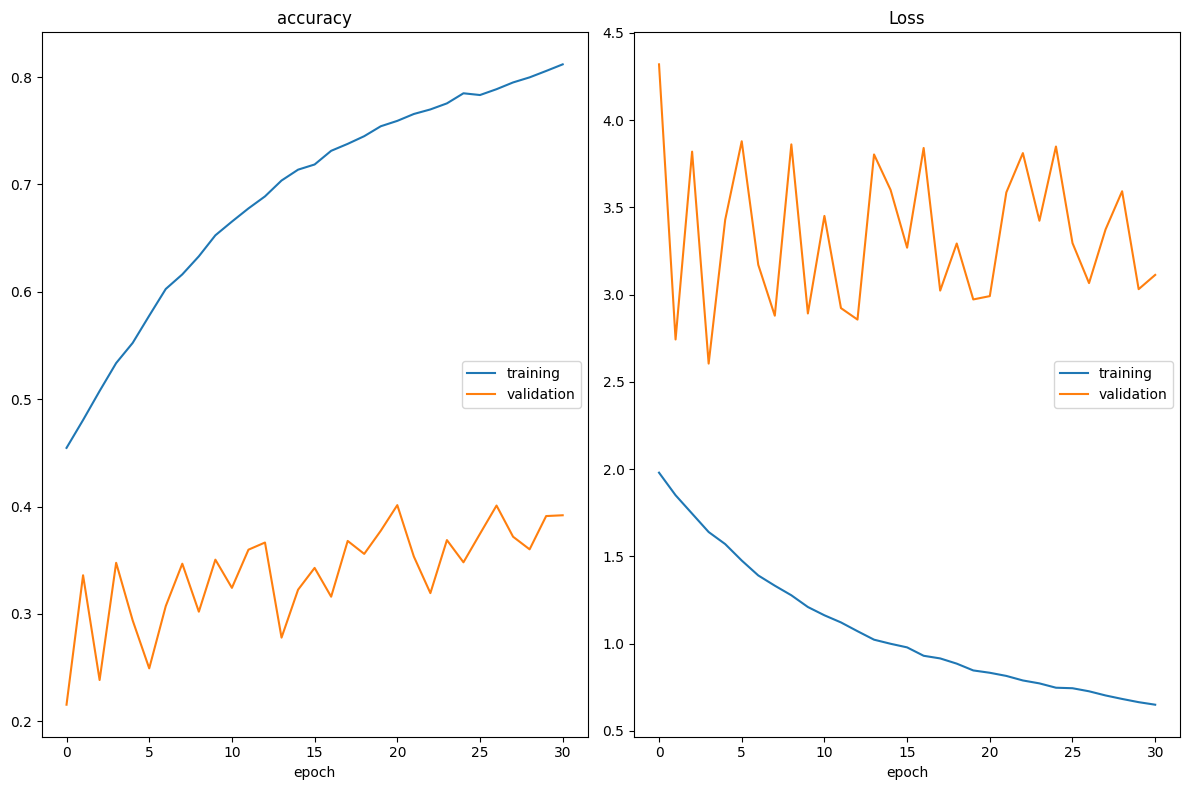

accuracy
	training         	 (min:    0.455, max:    0.812, cur:    0.812)
	validation       	 (min:    0.215, max:    0.401, cur:    0.392)
Loss
	training         	 (min:    0.650, max:    1.980, cur:    0.650)
	validation       	 (min:    2.605, max:    4.320, cur:    3.114)

Epoch 31: val_accuracy did not improve from 0.40137
966/966 [==============================] - 219s 227ms/step - loss: 0.6504 - accuracy: 0.8119 - val_loss: 3.1136 - val_accuracy: 0.3919


In [24]:
# Reprendre l'entraînement du modèle en utilisant les données augmentées et les données originales
epochs=50
history = saved_model.fit(combined_train_data,
                          epochs=epochs,
                          validation_data=val_data,
                          callbacks=callbacks)

In [25]:
test_loss, test_accuracy = saved_model.evaluate(test_data)
print('Test Loss:', test_loss)
print("Test Accuracy:", test_accuracy)

65/65 [==============================] - 5s 69ms/step - loss: 3.0263 - accuracy: 0.4043
Test Loss: 3.026261568069458
Test Accuracy: 0.4043269157409668


In [4]:
!pip install Graphviz

!pip install pydot

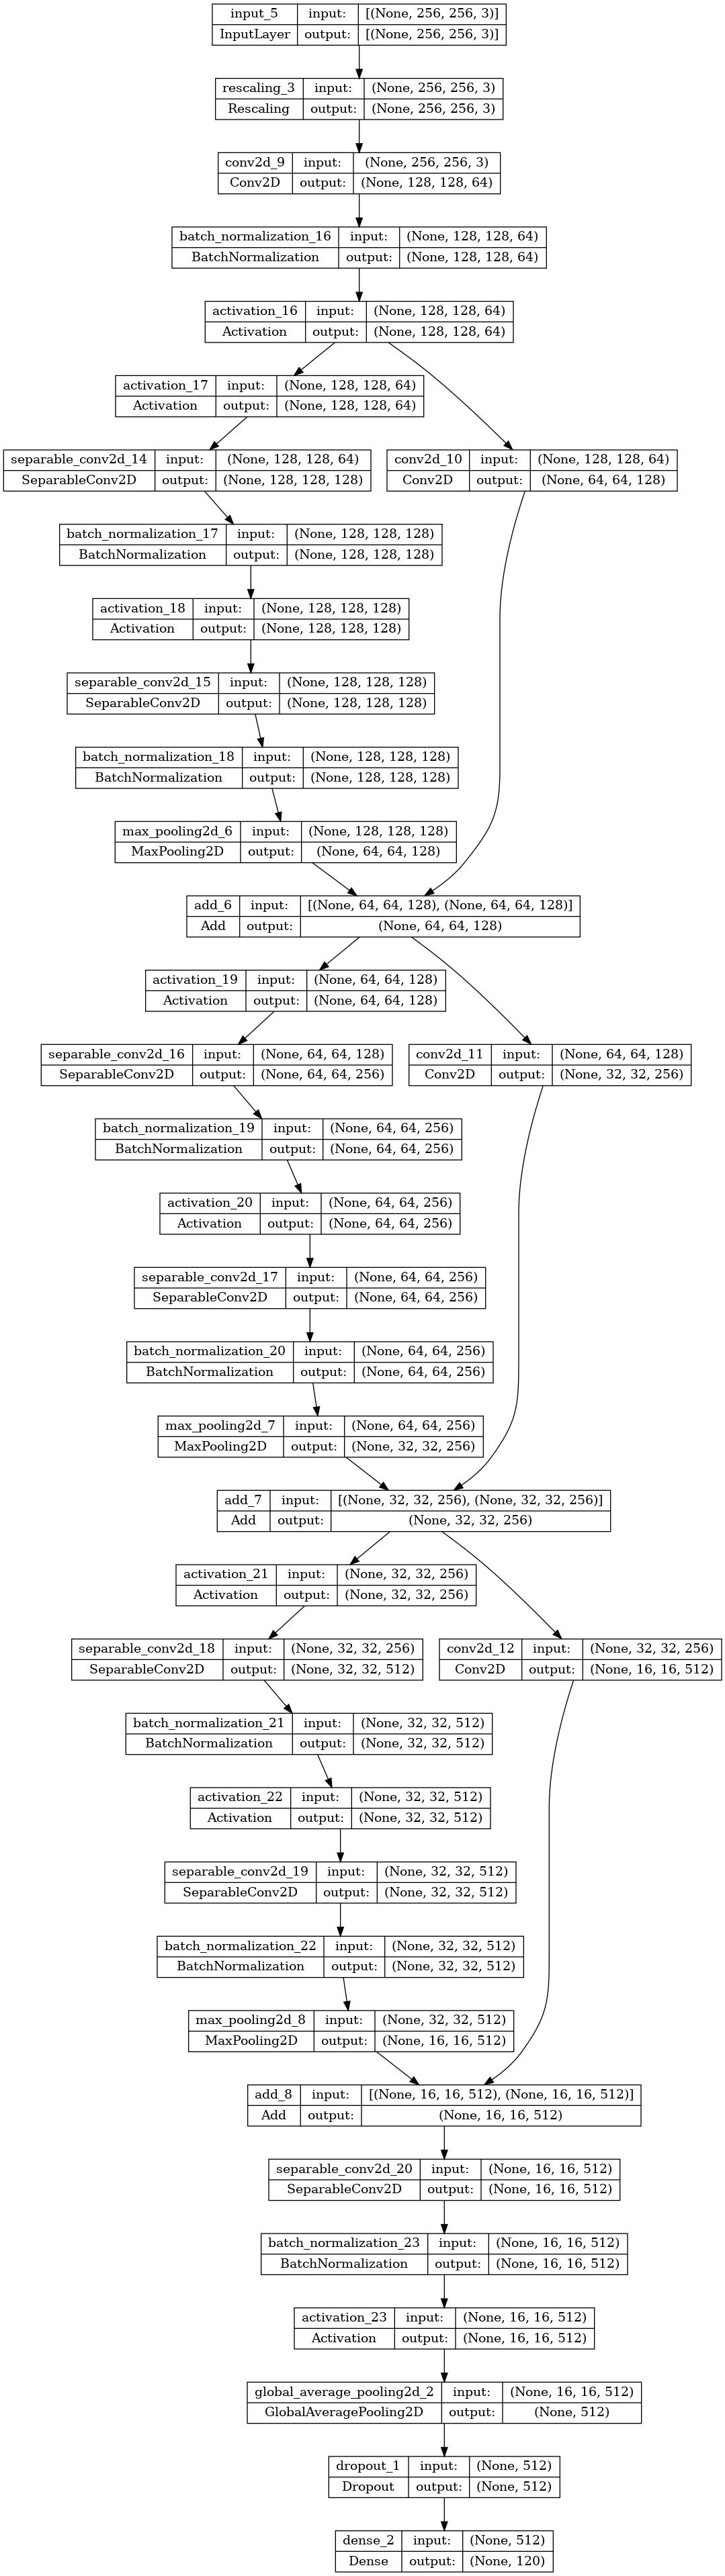

In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

# Charger le modèle à partir du fichier .h5
model = load_model('model_all_last_improuved.h5')

# Générer une représentation visuelle de l'architecture du modèle
plot_model(model, to_file='architecture_model_all_last_improuved.h5.png', show_shapes=True, show_layer_names=True)


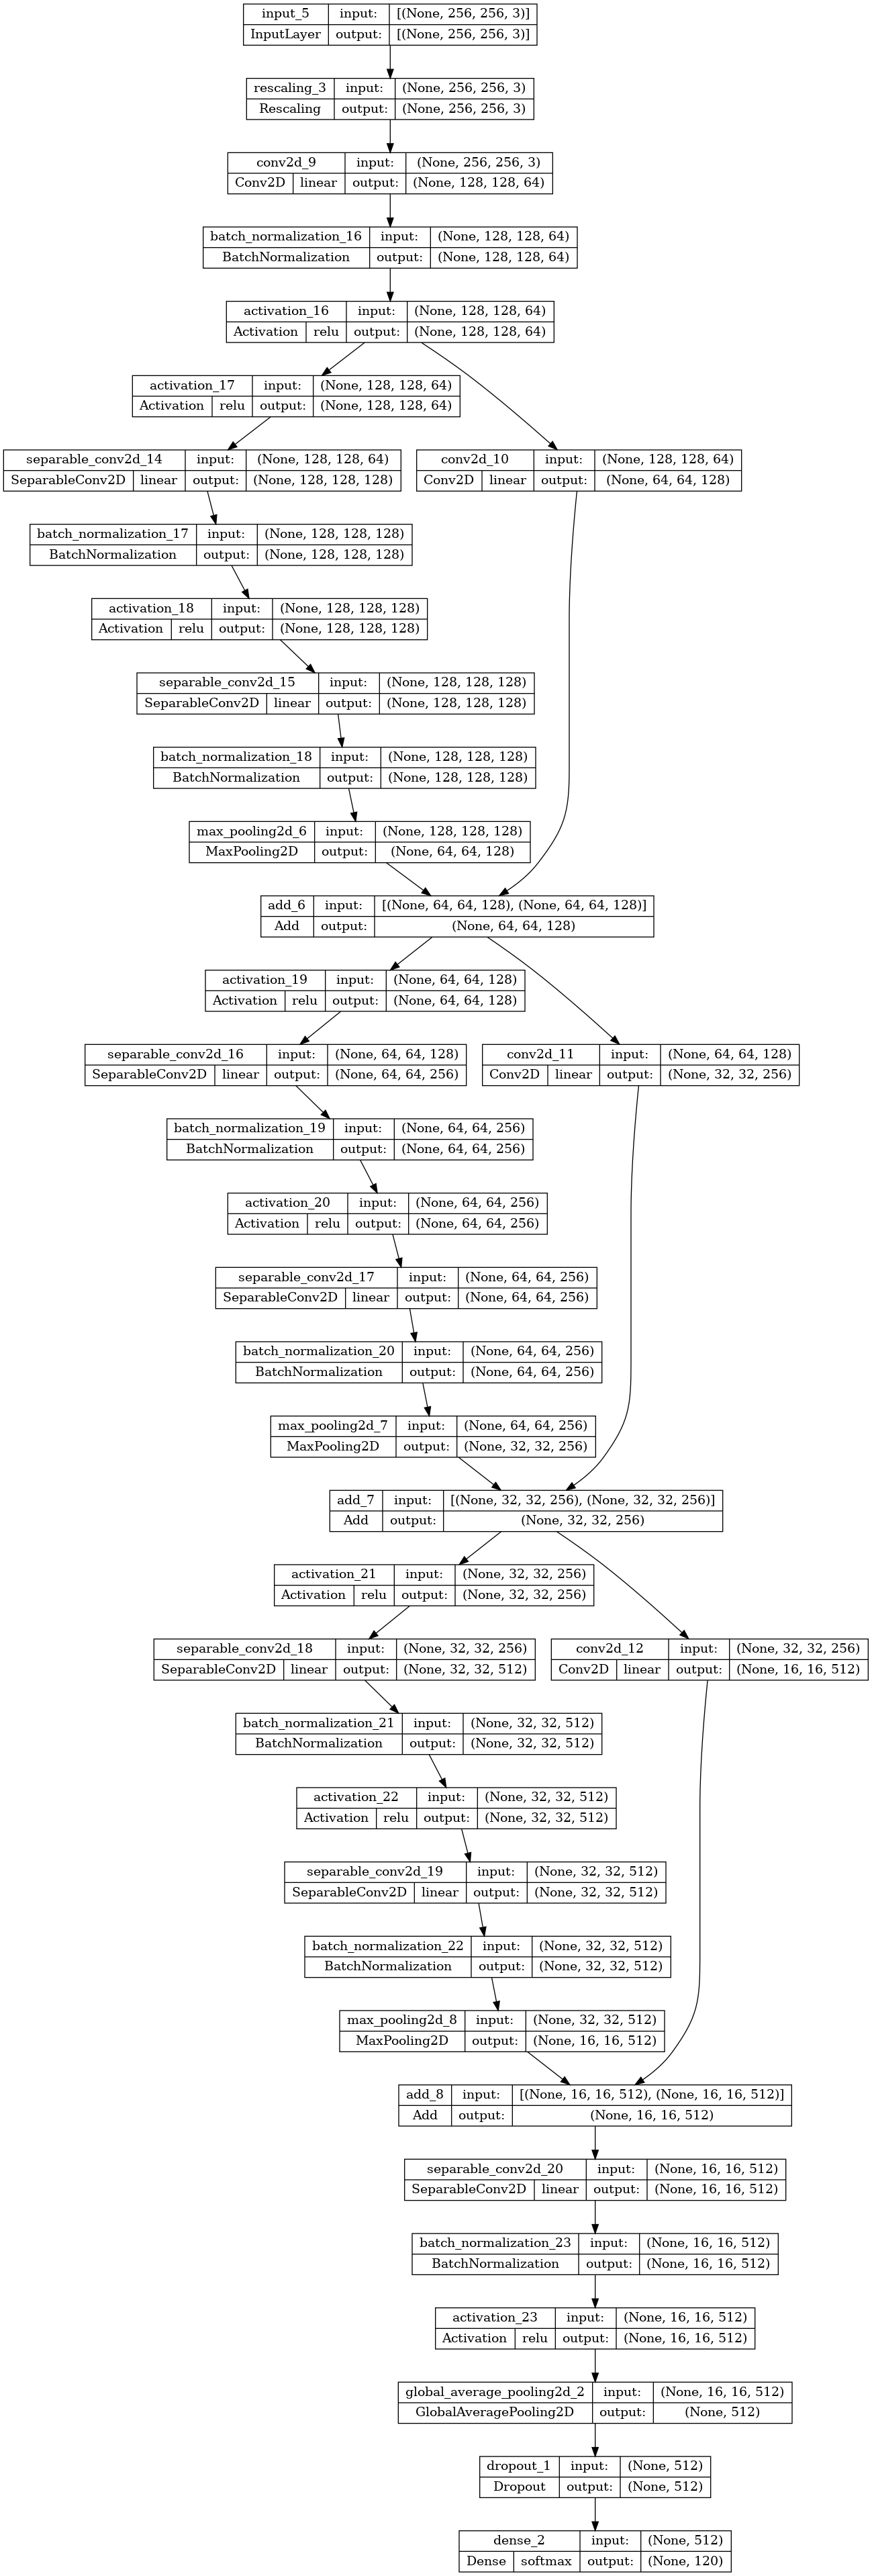

In [12]:
from tensorflow.keras.utils import plot_model

# Charger le modèle
model = load_model('model_all_last_improuved.h5')

# Générer une représentation visuelle de l'architecture du modèle
plot_model(model, to_file='architecture_model.png', show_shapes=True, show_layer_activations=True, show_layer_names=True)

In [14]:
!pip install netron

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.5 MB/s eta 0:00:00m eta 0:00:010:00:01


In [15]:
import netron
from tensorflow.keras.models import load_model

# Charger le modèle
model = load_model('model_all_last_improuved.h5')

# Visualiser l'architecture du modèle
netron.start('model_all_last_improuved.h5')

Serving 'model_all_last_improuved.h5' at http://localhost:8080


('localhost', 8080)

In [ ]:
first_cnn = load_model('')
netron.start('')